In [17]:
import matplotlib.pyplot as plt
import optuna
import numpy as np
from optuna.samplers import TPESampler

from snn.layers import SCTNLayer
from snn.spiking_network import SpikingNetwork
from snn.spiking_neuron import create_SCTN, IDENTITY
from snn.resonator import test_resonator_on_chirp

In [178]:
def neuron_output(neuron, rolling_window, duration, signal_freq, shift_degrees=0):
    y_events = neuron.out_spikes()
    cycles = 5
    samples_per_cycle =  clk_freq / signal_freq
    samples_per_degree = samples_per_cycle/360
    shift_samples = int(shift_degrees*samples_per_degree)
    y_events = y_events[
        (y_events > (duration - ((8+cycles)/signal_freq)) * clk_freq + shift_samples) &
        (y_events < (duration - (8/signal_freq)) * clk_freq + shift_samples)
    ]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    return y_spikes_rollsum

def generate_and_input_signal(resonator, duration, f):
    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * f
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

def resonator_from_optuna(freq0, lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain=1, clk_freq=1_536_000):
    LF = lf_lp_option
    LP = lp_by_lf(LF, freq0, clk_freq)
    f_resonator = freq_of_resonator(clk_freq, LF, LP)
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.synapses_weights = np.array([weight_input, -weight_feedback], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_input
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.synapses_weights = np.array([weight], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = theta
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def objective(trial):
    gain = max(1, freq0 / 104)
    theta_input=trial.suggest_int('theta_input', -int(gain*10), -int(gain*1))
    theta=trial.suggest_int('theta', -int(gain*10), -int(gain*1))
    weight_input=trial.suggest_int('weight_input', int(gain*5), int(gain*15))
    weight_feedback=trial.suggest_int('weight_feedback', int(gain*5), int(gain*15))
    weight=trial.suggest_int('weight', int(gain*5), int(gain*15))
    amplitude_gain=1

    resonator = resonator_from_optuna(freq0, lf_lp_option, theta_input, theta, weight_input, weight_feedback, weight, amplitude_gain, clk_freq)
    return  score_resonator(resonator, duration=duration, freq0=freq0)

def score_resonator(resonator, duration, freq0, plot=False):
    for i in range(0, 5):
        resonator.log_out_spikes(i)

    x = np.linspace(0, duration, int(duration * resonator.clk_freq))
    t = x * 2 * np.pi * freq0
    sine_wave = np.sin(t)
    resonator.input_full_data(sine_wave)

    try:
        spikes_roll = np.array([neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
                                for i in range(0, 5)])
    except ValueError:
        return np.inf

    if plot:
        for i in range(5):
            plt.plot(spikes_roll[i], label=f'output of {i}')
        plt.legend()
    mse = 0
    for i in range(0, 4):
        mse += ((ground_truth[i] - spikes_roll[i+1]) ** 2).mean()
    return mse

43.62093677931481
44.16720524368671
43.51565608776997
37.77432277401498
mse 2205.8789869866937


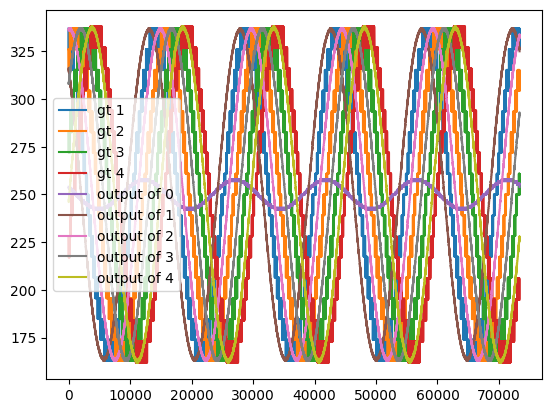

In [172]:
freq0 = 104
freq_base = 104
clk_freq = 1536000
duration = .6
spikes_window_size = 500
lf_lp_option = 5

base_params = {
    'theta_input': -1,
    'theta': -5,
    'weight_input': 11,
    'weight_feedback': 9,
    'weight': 10,
}
base_resonator = resonator_from_optuna(freq_base, **base_params, lf_lp_option=5, clk_freq=clk_freq)
desired_resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
desired_resonator.log_out_spikes(0)
for i in range(0, 5):
    base_resonator.log_out_spikes(i)
generate_and_input_signal(base_resonator, duration, freq_base)
generate_and_input_signal(desired_resonator, duration, freq0)
ground_truth_104 = np.array([neuron_output(base_resonator.neurons[i], spikes_window_size, duration, freq_base) for i in range(0, 5)])

phase_shift = 0
ground_truth = []
for i in range(1, 5):
    j = i - 1
    norm_x0 = (ground_truth_104[j] - ground_truth_104[j].min()) / (ground_truth_104[j].max() - ground_truth_104[j].min()) * 2 -1
    max_xi = ground_truth_104[i].max()
    min_xi = ground_truth_104[i].min()
    norm_x1 = (ground_truth_104[i] - min_xi) / (max_xi - min_xi) * 2 -1
    align_norms = np.array([norm_x1[::20], norm_x0[::20]])
    cov = np.cov(np.transpose(align_norms))
    phi = np.arccos(cov[1, 0])*180/np.pi/2
    print(phi)
    phase_shift -= phi
    gt_i = neuron_output(desired_resonator.neurons[0], spikes_window_size, duration, freq0, phase_shift)
    gt_i = (gt_i - gt_i.min())/(gt_i.max() - gt_i.min())
    gt_i = gt_i * (max_xi - min_xi) + min_xi
    ground_truth.append(gt_i)
    plt.plot(gt_i, label=f'gt {i}')

ground_truth = np.array(ground_truth)
if freq0 == freq_base:
    # for testing the mse of the ground truth vs what we are searching
    mse = score_resonator(base_resonator, duration=duration, freq0=freq0, plot=True)
    print(f'mse {mse}')

In [166]:
from optuna.distributions import DiscreteUniformDistribution
import time

study_name = f'Study{clk_freq}-{freq0}'
study = optuna.create_study(study_name=study_name,
                            pruner=optuna.pruners.HyperbandPruner(),
                            sampler=TPESampler(seed=43,
                                               # consider_prior=DiscreteUniformDistribution()
                                               ),
                            direction='minimize',
                            load_if_exists=True)

[I 2023-06-19 16:55:41,834] A new study created in memory with name: Study1536000-139


In [167]:
ts = time.time()
study.optimize(objective, n_trials=100)
print(f'{time.time() - ts} seconds.')

[I 2023-06-19 16:55:42,933] Trial 0 finished with value: inf and parameters: {'theta_input': -12, 'theta': -6, 'weight_input': 8, 'weight_feedback': 9, 'weight': 10}. Best is trial 0 with value: inf.
[I 2023-06-19 16:55:44,068] Trial 1 finished with value: 148709.80768490996 and parameters: {'theta_input': -2, 'theta': -5, 'weight_input': 14, 'weight_feedback': 6, 'weight': 17}. Best is trial 1 with value: 148709.80768490996.
[I 2023-06-19 16:55:45,184] Trial 2 finished with value: inf and parameters: {'theta_input': -8, 'theta': -3, 'weight_input': 9, 'weight_feedback': 6, 'weight': 18}. Best is trial 1 with value: 148709.80768490996.
[I 2023-06-19 16:55:46,273] Trial 3 finished with value: inf and parameters: {'theta_input': -11, 'theta': -8, 'weight_input': 10, 'weight_feedback': 7, 'weight': 18}. Best is trial 1 with value: 148709.80768490996.
[I 2023-06-19 16:55:47,389] Trial 4 finished with value: inf and parameters: {'theta_input': -2, 'theta': -1, 'weight_input': 11, 'weight_fe

112.71634221076965 seconds.


mse 33822.211379684675


{'theta_input': -1,
 'theta': -7,
 'weight_input': 15,
 'weight_feedback': 13,
 'weight': 13}

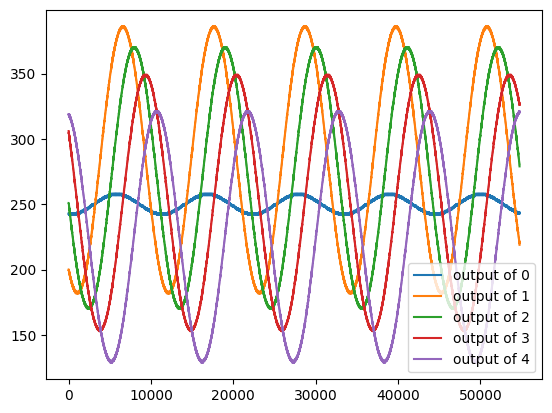

In [168]:
# 118 {'theta_input': -1.161, 'theta': -4.943, 'weight_input': 8.512, 'weight_feedback': 8.867, 'weight': 10.342}
best_params = study.best_params.copy()

resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, clk_freq=clk_freq)
mse = score_resonator(resonator, duration=.3, freq0=freq0, plot=True)
print(f'mse {mse}')
best_params

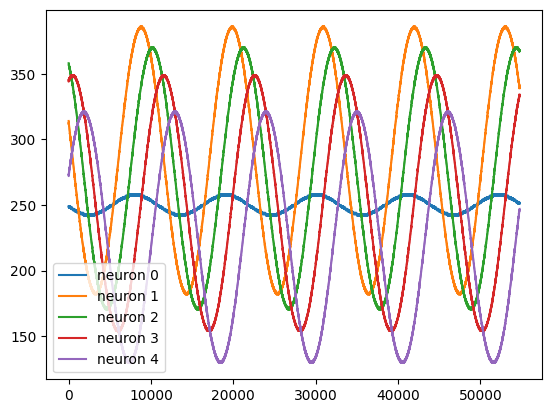

In [169]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)

generate_and_input_signal(resonator, duration, freq0)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


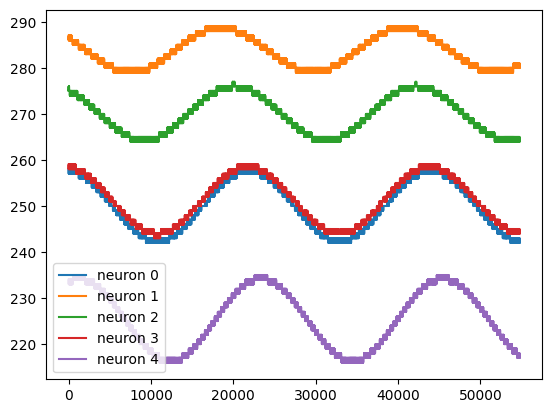

In [170]:
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
for i in range(len(resonator.neurons)):
    resonator.log_out_spikes(i)


generate_and_input_signal(resonator, duration, freq0 / 2)

for i in range(len(resonator.neurons)):
    try:
        normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0)
        plt.plot(normalize_roll, label=f'neuron {i}')
    except ValueError:
        plt.plot([0], label=f'neuron {i} didnt emit spikes')

plt.legend()


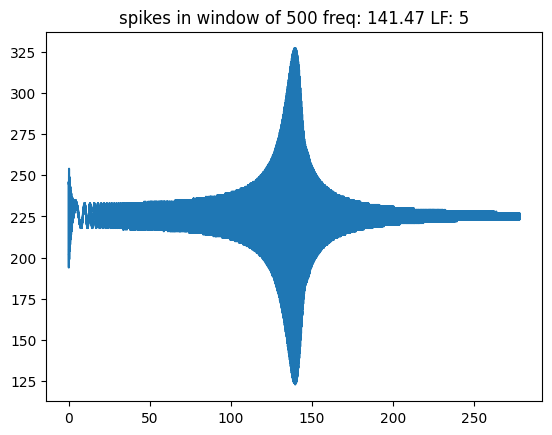

In [171]:
from snn.resonator import lp_by_lf, freq_of_resonator

start_freq = 0
spectrum = 2 * freq0
resonator = resonator_from_optuna(freq0, **best_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
# resonator = resonator_from_optuna(freq0, **base_params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator.log_out_spikes(-1)

step = 1 / 40000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 500
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

best_lp = lp_by_lf(lf_lp_option, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf_lp_option, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f} LF: {lf_lp_option}')
plt.plot(x, y_spikes)
plt.show()

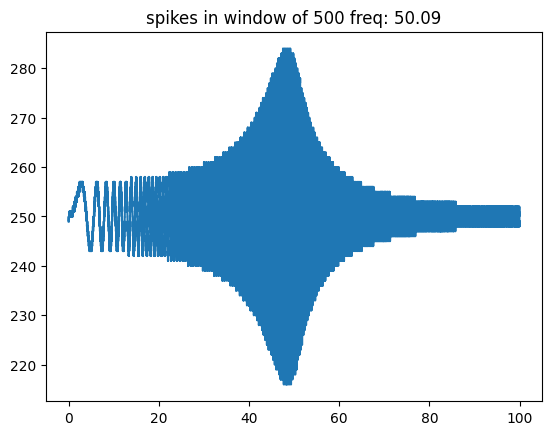

In [188]:
from snn.resonator import lp_by_lf, freq_of_resonator

start_freq = 0

params = {
    "theta_input": -1,
    "theta": -4,
    "weight_input": 15,
    "weight_feedback": 13,
    "weight": 8,
}
freq0 = 50
lf_lp_option = 4

spectrum = 2 * freq0
resonator = resonator_from_optuna(freq0, **params, lf_lp_option=lf_lp_option, clk_freq=clk_freq)
resonator.log_out_spikes(-1)

step = 1 / 100000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 500
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))

best_lp = lp_by_lf(lf_lp_option, freq0, clk_freq)
f_resonator = freq_of_resonator(clk_freq, lf_lp_option, best_lp)
plt.title(f'spikes in window of {spikes_window_size} freq: {f_resonator:.2f}')
plt.plot(x, y_spikes)
plt.show()